In [63]:
import geopandas
import libpysal
import momepy
import osmnx
import pandas
import shapely
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import _agglomerative
from sklearn.decomposition import PCA
from sklearn import metrics
from libpysal.weights import KNN
from libpysal.weights import Queen
import contextily as cx
import numpy
import pickle
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [81]:
standardized = pandas.read_parquet('data/contextual.pq').fillna(0)
merged = geopandas.read_file('data/primary.gpkg', layer='tessellation')
buildings = geopandas.read_file('data/primary.gpkg', layer="buildings")

In [84]:
streets = geopandas.read_file('data/geometry_umm.gpkg', layer="streets")

### How many clusters?

In [72]:
# Build spatial matrix. We tried different methods and KNN seems the best so far.
n=2
w = KNN.from_dataframe(merged, k=n)

C:\ProgramData\miniconda3\envs\ox\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 140 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


### Compute entire tree

In [73]:
%%time
numpy.random.seed(123456) #for reproducibility
model = AgglomerativeClustering(linkage='ward', connectivity=w.sparse, n_clusters=None, distance_threshold=0)
model.fit(standardized)

C:\ProgramData\miniconda3\envs\ox\Lib\site-packages\sklearn\cluster\_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 140 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: total: 3min 13s
Wall time: 14.9 s


AgglomerativeClustering(connectivity=<16437x16437 sparse matrix of type '<class 'numpy.float64'>'
	with 32874 stored elements in Compressed Sparse Row format>,
                        distance_threshold=0, n_clusters=None)

Save the model on file

In [74]:
model_file = 'data/AHC_knn'+str(n)+'.pkl'
with open(model_file, 'wb') as fout:
    pickle.dump(model, fout)

### Test different clustering solutions

In [7]:
# #reload the model
# model_file = 'data/AHC_knn'+str(n)+'.pkl'
# with open(model_file, 'rb') as fin:
#     model = pickle.load(fin)
# model.get_params()

In [10]:
%%time
standardized_copy = standardized.copy()
#standardized_copy = pandas.DataFrame(standardized_copy)

K = range(2,20) 
#print(f'Calculating Davies-boulding (DB, lower is better) and Calinski Harabasz (CH, higher is better)')
db_score_list = []
ch_score_list = []
s_score_list = []
for k in K: 
    # cuts the dendrogram to get k clusters
    labels = _agglomerative._hc_cut(k, model.children_, model.n_leaves_)
    
    # Davies-boulding, Calinski Harabasz
    db_score = metrics.davies_bouldin_score(standardized, labels)
    ch_score = metrics.calinski_harabasz_score(standardized, labels)
    db_score_list.append(db_score)
    ch_score_list.append(ch_score)
    print(f'k={k} : DB={db_score}, CH={ch_score}')    

    # silhouette on sample
    standardized_copy['label'] = labels
    standardized_sample = standardized_copy#.sample(20000)
    labels_sample = standardized_sample['label']
    standardized_sample.drop(columns=['label'])
    s_score = metrics.silhouette_score(standardized_sample, labels_sample)
    s_score_list.append(s_score)
    print(f'k={k} : S={s_score}')

k=2 : DB=1.0640744382812612, CH=1168.571804636937
k=2 : S=0.556189830956275
k=3 : DB=2.424342034593112, CH=991.6039929487132
k=3 : S=0.1872018972538879
k=4 : DB=3.43908257117248, CH=811.7512615228719
k=4 : S=0.07110941758352081
k=5 : DB=2.9754879996426995, CH=690.291277524426
k=5 : S=0.06577687274114603
k=6 : DB=2.8099920777852723, CH=613.971734702243
k=6 : S=0.0579287226574583
k=7 : DB=3.112536105540957, CH=561.5988436575215
k=7 : S=0.04321409024017547
k=8 : DB=3.0986257697683506, CH=519.1581888452554
k=8 : S=0.047324549509435494
k=9 : DB=3.1330840290774074, CH=486.5949566331474
k=9 : S=0.06331070838992756
k=10 : DB=3.428961405876966, CH=460.0832780013483
k=10 : S=0.015594894837521921
k=11 : DB=3.5156408253557974, CH=432.7770705728342
k=11 : S=0.027921749723894884
k=12 : DB=3.409103567270454, CH=409.30024699100335
k=12 : S=0.03549601165636434
k=13 : DB=3.490753772089535, CH=389.8755557287184
k=13 : S=0.03742828883324558
k=14 : DB=3.315969103436752, CH=373.3614064449685
k=14 : S=0.0393

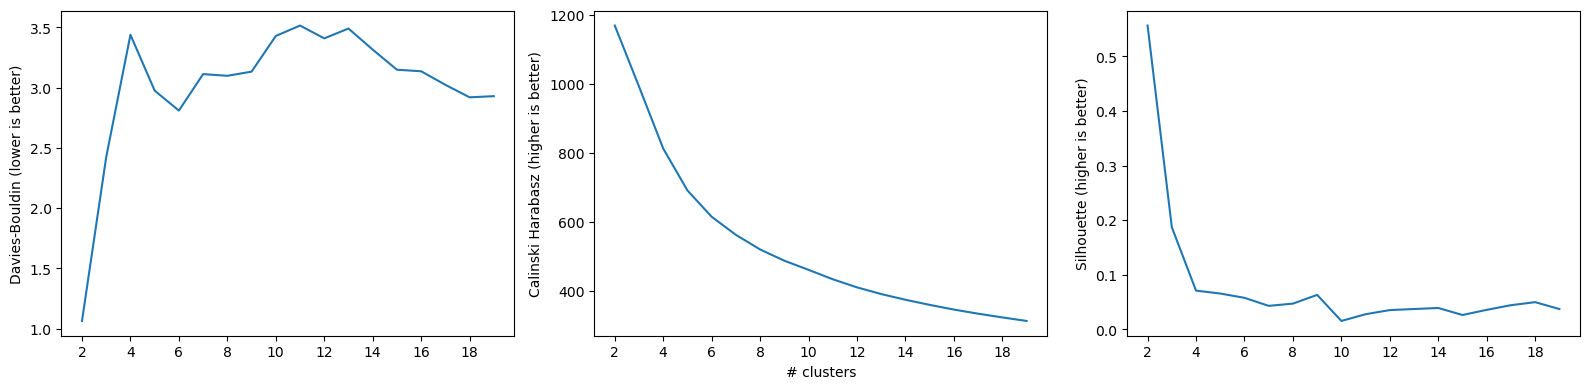

In [11]:
#explanation of the two indices
#https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.plot(list(K), db_score_list)
ax2.plot(list(K), ch_score_list)
ax3.plot(list(K), s_score_list)
ax1.set_ylabel('Davies-Bouldin (lower is better)')
ax2.set_ylabel('Calinski Harabasz (higher is better)')
ax3.set_ylabel('Silhouette (higher is better)')
ax2.set_xlabel('# clusters')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

In [118]:
k=9 #number of urban types selected

In [119]:
#obtain labels for best solution
labels_f = _agglomerative._hc_cut(k, model.children_, model.n_leaves_)

In [120]:
merged["cluster"] = labels_f

In [121]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID", how='inner')
urban_types = urban_types.drop_duplicates('uID')
len(urban_types)

13981

In [122]:
# urban_types.plot("cluster", categorical=True, cmap='tab20', figsize=(15, 15), legend=True).set_axis_off()

In [123]:
urban_types.to_file('results/urban_types_ahc_k'+str(k)+'.gpkg')

In [124]:
# #remove outliers (cluster 7) and save
# urban_types.loc[urban_types.cluster != 7].to_file('_results/urban_types_ahc_k'+str(k-1)+'.gpkg')

In [125]:
urban_types_ = pandas.concat([standardized, merged[["tID","geometry","cluster"]]], axis = 1)
urban_types_ = geopandas.GeoDataFrame(urban_types_, geometry='geometry')
len(urban_types_)

16437

In [126]:
# #remove outliers (cluster 7) and save
# urban_types_ = urban_types_.loc[urban_types_.cluster != 7]

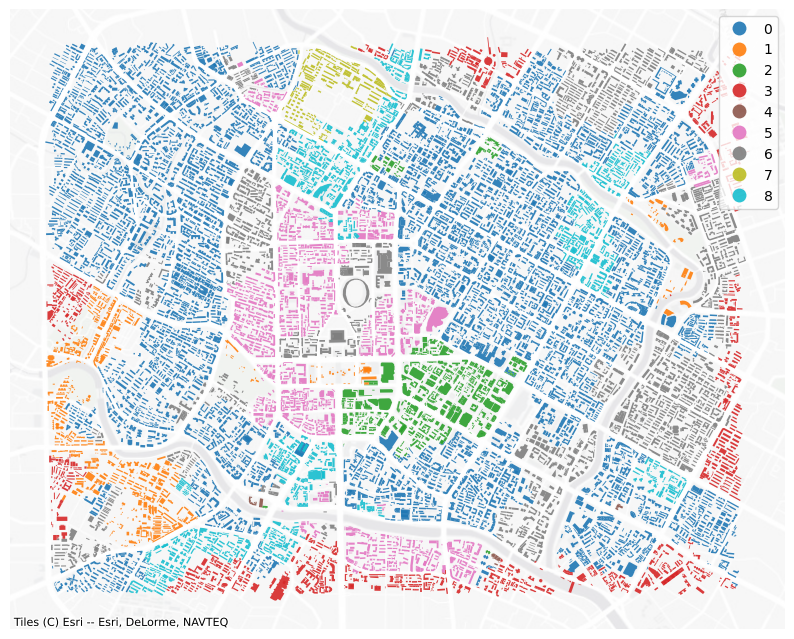

In [127]:
ax = urban_types.plot('cluster', categorical=True, legend=True, alpha=.9, figsize=(10,10))
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldGrayCanvas, crs=urban_types_.crs, alpha=.5, zorder=0)
ax.set_axis_off()

In [128]:
# urban_types_ = urban_types.merge(standardized, left_index=True, right_index=True)

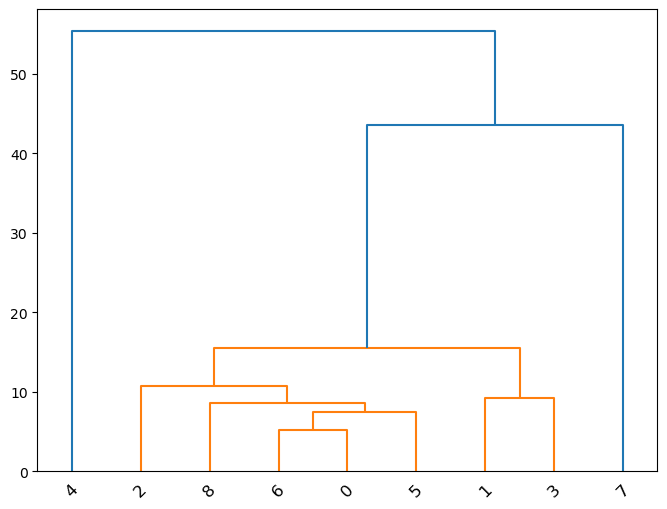

In [129]:
group = urban_types_.drop(columns=['tID','geometry']).groupby('cluster').mean()
Z = hierarchy.linkage(group, 'ward', optimal_ordering=True) #optimal_ordering=True
plt.figure(figsize=(8, 6))
dn = hierarchy.dendrogram(Z, labels=group.index)
plt.xticks(rotation = 45)
plt.show()

## plot with proper colors

In [131]:
#https://htmlcolors.com/color-picker
colors = [(26, 0, 50), #grey 

          (120, 100, 50), #dark green
          (98, 93, 78), #light green
          (75, 90, 85), #yellow
          (40, 100, 60), #orange 
          (14, 79, 58), #red
          (347, 72, 60), #pink
          
          (275, 100, 25), #purple
          (257, 71, 45), #blue
          (246, 79, 60), #light blue
         ]

cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=11)
    for rgb in pal[1:]:
        cols.append(rgb)

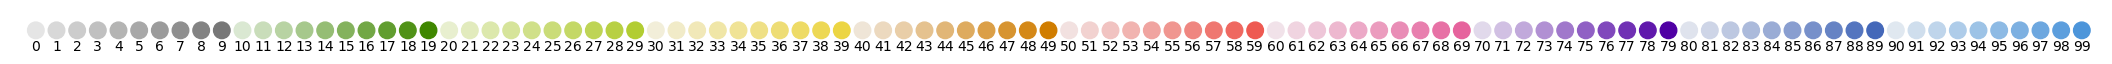

In [132]:
fig, ax = plt.subplots(figsize=(27, 6))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))
    plt.text(i, -1, i, horizontalalignment='center')
    ax.set_axis_off()
    ax.set_aspect(1)
    ax.autoscale()
    plt.xlim(-1.25,100)
    plt.ylim(-1,1)

In [130]:
# symbology = {4: cols[89],
             
#              5: cols[59],
#              0: cols[54],
             
#              1: cols[49],
             
#              2: cols[39],
             
#              3: cols[29]
#             }

In [153]:
symbology = {4: cols[9],

             2: cols[39],
             
             8: cols[34],
             
             6: cols[49],
             0: cols[44],
             
             5: cols[59],
             
             1: cols[66],
             3: cols[62],
             
             7: cols[94]
            }

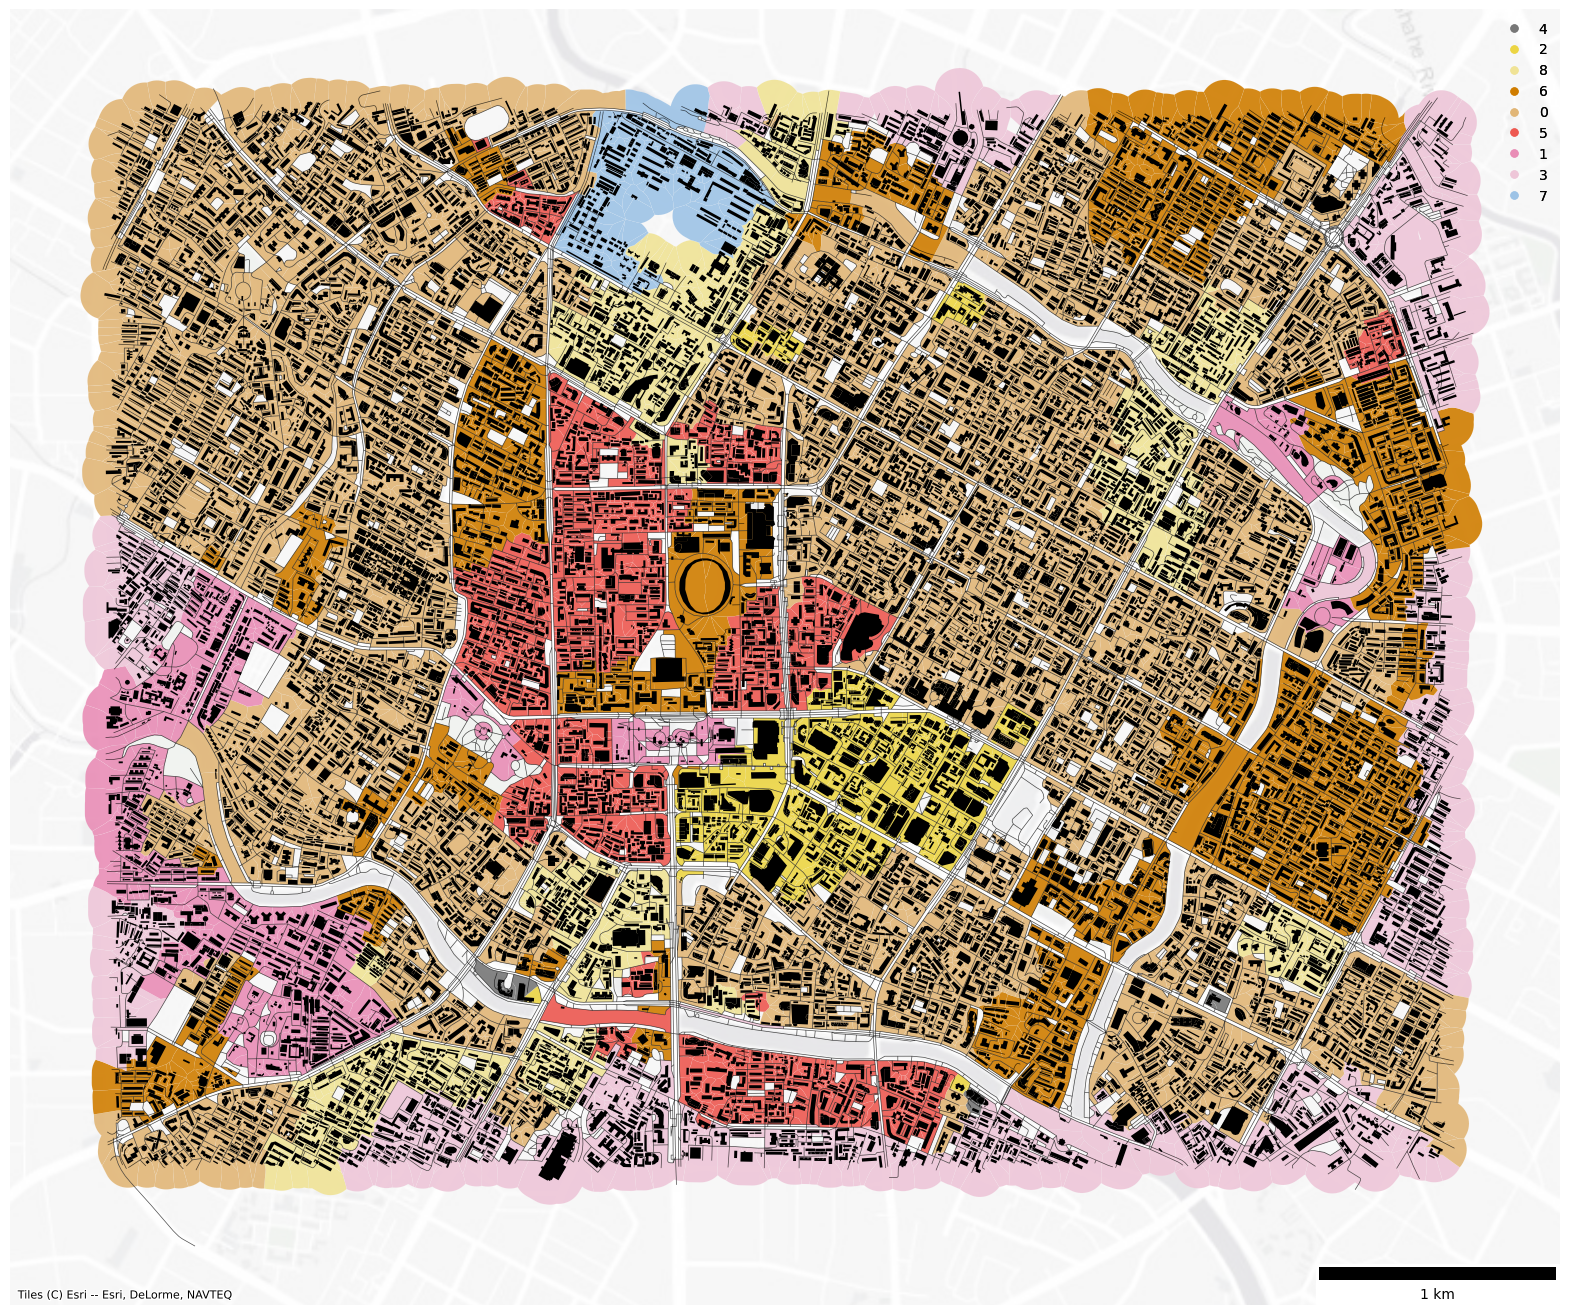

In [160]:
ax = urban_types_.plot(color=urban_types_['cluster'].map(symbology), categorical=True, legend=True,
                       edgecolor='w', lw=.05,
                       figsize=(20, 20), alpha=.9, zorder=1)

urban_types.plot(facecolor='k', edgecolor='None', zorder=2, ax=ax)

streets.plot(ax=ax, edgecolor="k", lw=0.5, alpha=0.7, zorder=3)

# buildings.plot(ax=ax, 
#                edgecolor="k", lw=0.05, 
#                facecolor="None", #alpha=0.7, 
#                zorder=3)

cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldGrayCanvas, crs=urban_types_.crs, alpha=.5, zorder=0)

ax.set_axis_off()
#plt.title("UMM taxonomy of Turin")

custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax.add_artist(ScaleBar(1, location='lower right'))
ax.add_artist(leg_points)
plt.savefig('results/map_AHC_k'+str(len(urban_types_.cluster.unique()))+'.jpeg', dpi=600, bbox_inches='tight')

In [155]:
# ini_list = [0,1,2,3,4,5,6]
# symbology_ = dict(zip(ini_list, list(symbology.values())))

In [158]:
ini_list = [0,1,2,3,4,5,6,7,8]
symbology_ = dict(zip(ini_list, list(symbology.values())))

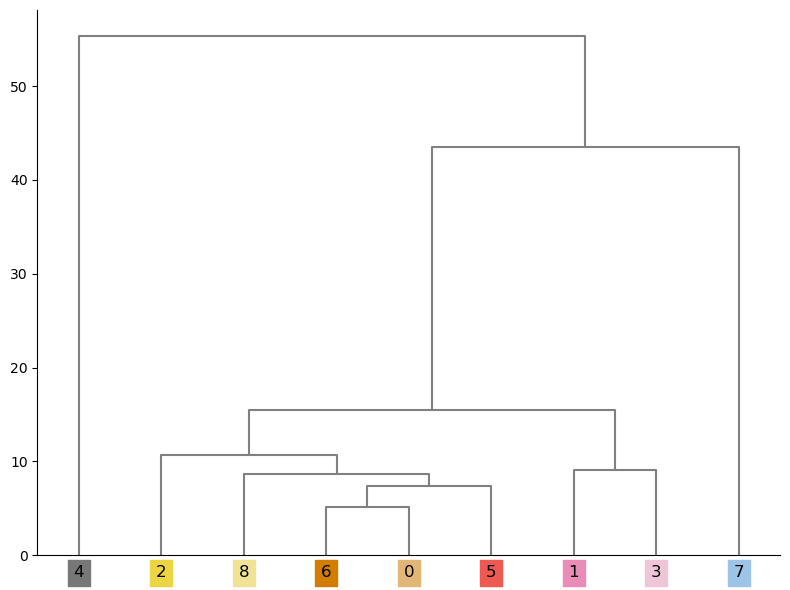

In [161]:
plt.figure(figsize=(8, 6))
dn = hierarchy.dendrogram(Z, labels=group.index, color_threshold=0, above_threshold_color='grey')

#plt.title(f"{subset_dist}m")

# Applying the color palette to the dendrogram
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for i, x_label in enumerate(x_labels):
    idx = int(x_label.get_text())
    x_label.set_backgroundcolor(symbology_[i])

ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig('results/dendro_ahc_k'+str(len(urban_types_.cluster.unique()))+'.jpeg', dpi=600)